In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
seed = 42

passengers = pd.read_csv("titanic_augmented.csv", dtype={"Pclass": str})

In [3]:
num_passengers = len(passengers)

print(f"Number of passengers: {num_passengers}")

Number of passengers: 891


# Handling Null Values

In [4]:
passengers.isna().sum()

PassengerId            0
Survived               0
Pclass                 0
Name                   0
Sex                    0
Age                  177
SibSp                  0
Parch                  0
Ticket                 0
Fare                   0
Cabin                687
Embarked               2
name_length            0
title                  0
title_group            0
family_size            0
is_alone               0
ticket_group_size      0
fare_per_person        0
age_fare_ratio         0
cabin_deck             0
cabin_room_number    691
booking_reference      0
service_id             0
cabin_score            0
name_word_count        0
dtype: int64

In [5]:
num_null_age = passengers.Age.isna().sum()
num_null_cabin = passengers.Cabin.isna().sum()
num_null_embarked = passengers.Embarked.isna().sum()
num_null_cabin_room_number = passengers.cabin_room_number.isna().sum()

print(f"Age: {num_null_age}/{num_passengers} ({round(num_null_age/num_passengers*100, 3)}%) are null")
print(f"Cabin: {num_null_cabin}/{num_passengers} ({round(num_null_cabin/num_passengers*100, 3)}%) are null")
print(f"Embarked: {num_null_embarked}/{num_passengers} ({round(num_null_embarked/num_passengers*100, 3)}%) are null")
print(f"cabin_room_number: {num_null_cabin_room_number}/{num_passengers} ({round(num_null_cabin_room_number/num_passengers*100, 3)}%) are null")

Age: 177/891 (19.865%) are null
Cabin: 687/891 (77.104%) are null
Embarked: 2/891 (0.224%) are null
cabin_room_number: 691/891 (77.553%) are null


## Cabin and cabin_room_number

In [6]:
passengers = passengers.drop(columns=['Cabin', 'cabin_room_number'])

## Embarked

In [7]:
passenger_embarked_counts = passengers.Embarked.value_counts()

print(f"{passenger_embarked_counts.S}/{num_passengers} ({round(passenger_embarked_counts.S/num_passengers*100, 3)}%) of passengers embarked from port S")
print(f"{passenger_embarked_counts.C}/{num_passengers} ({round(passenger_embarked_counts.C/num_passengers*100, 3)}%) of passengers embarked from port C")
print(f"{passenger_embarked_counts.Q}/{num_passengers} ({round(passenger_embarked_counts.Q/num_passengers*100, 3)}%) of passengers embarked from port Q")

644/891 (72.278%) of passengers embarked from port S
168/891 (18.855%) of passengers embarked from port C
77/891 (8.642%) of passengers embarked from port Q


In [8]:
passengers.groupby(["Sex", "Pclass"]).Embarked.apply(lambda p: p.mode()[0])

Sex     Pclass
female  1         S
        2         S
        3         S
male    1         S
        2         S
        3         S
Name: Embarked, dtype: object

In [9]:
passengers["Embarked"] = passengers.Embarked.fillna("S")

## Age

In [10]:
passengers.groupby(["Sex", "Pclass"]).Age.apply(lambda p: p.mode()[0])

Sex     Pclass
female  1         35.0
        2         24.0
        3         18.0
male    1         36.0
        2         23.0
        3         22.0
Name: Age, dtype: float64

In [11]:
passengers["Age"] = passengers["Age"].fillna(passengers.groupby(["Sex", "Pclass"]).Age.transform(lambda p: p.mode()[0]))

## cabin_deck

In [12]:
string_columns = passengers.select_dtypes(include="object")

string_columns.head()

,Pclass,Name,Sex,Ticket,Embarked,title,title_group,cabin_deck
0,3,"Braund, Mr. Owen Harris",male,A/5 21171,S,Mr,Mr,Unknown
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C,Mrs,Mrs,C
2,3,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,S,Miss,Miss,Unknown
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,S,Mrs,Mrs,C
4,3,"Allen, Mr. William Henry",male,373450,S,Mr,Mr,Unknown


In [13]:
string_columns.cabin_deck.value_counts()

cabin_deck
Unknown    687
C           59
B           47
D           33
E           32
A           15
F           13
G            4
T            1
Name: count, dtype: int64

In [14]:
num_unkown_cabin_deck = len(passengers.query("cabin_deck == 'Unknown'"))

print(f"{num_unkown_cabin_deck}/{num_passengers} ({round(num_unkown_cabin_deck/num_passengers*100, 3)}%) have an unkown cabin_deck")

687/891 (77.104%) have an unkown cabin_deck


In [15]:
passengers = passengers.drop(columns=['cabin_deck'])

In [16]:
passengers.isna().sum()

PassengerId          0
Survived             0
Pclass               0
Name                 0
Sex                  0
Age                  0
SibSp                0
Parch                0
Ticket               0
Fare                 0
Embarked             0
name_length          0
title                0
title_group          0
family_size          0
is_alone             0
ticket_group_size    0
fare_per_person      0
age_fare_ratio       0
booking_reference    0
service_id           0
cabin_score          0
name_word_count      0
dtype: int64

# Feature Selection

In [17]:
passengers.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'name_length', 'title',
       'title_group', 'family_size', 'is_alone', 'ticket_group_size',
       'fare_per_person', 'age_fare_ratio', 'booking_reference', 'service_id',
       'cabin_score', 'name_word_count'],
      dtype='object')

## Useless Identifiers (PassengerId, service_id, Name, booking_reference, and Ticket)

In [18]:
passengers.select_dtypes(exclude="float").nunique()

PassengerId          891
Survived               2
Pclass                 3
Name                 891
Sex                    2
SibSp                  7
Parch                  7
Ticket               681
Embarked               3
name_length           50
title                 17
title_group            5
family_size            9
is_alone               2
ticket_group_size      7
booking_reference    681
service_id           891
name_word_count        8
dtype: int64

In [19]:
passengers[["PassengerId", "service_id", "Name", "booking_reference", "Ticket"]]

,PassengerId,service_id,Name,booking_reference,Ticket
0,1,221958,"Braund, Mr. Owen Harris",92490,A/5 21171
1,2,771155,"Cumings, Mrs. John Bradley (Florence Briggs Th...",15655423,PC 17599
2,3,231932,"Heikkinen, Miss. Laina",90218500,STON/O2. 3101282
3,4,465838,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2493079,113803
4,5,359178,"Allen, Mr. William Henry",59517148,373450
...,...,...,...,...,...
886,887,538661,"Montvila, Rev. Juozas",83757278,211536
887,888,498929,"Graham, Miss. Margaret Edith",91664020,112053
888,889,680466,"Johnston, Miss. Catherine Helen ""Carrie""",55618889,W./C. 6607
889,890,673695,"Behr, Mr. Karl Howell",94737372,111369


In [20]:
passengers = passengers.drop(columns=["PassengerId", "service_id", "Name", "booking_reference", "Ticket"])

## is_alone

In [21]:
print(f"Unique is_alone among SibSp == 0 and Parch == 0: {passengers[(passengers['SibSp'] == 0) & (passengers['Parch'] == 0)]['is_alone'].unique()}")
print(f"Unique is_alone among SibSp != 0 or Parch != 0: {passengers[(passengers['SibSp'] != 0) | (passengers['Parch'] != 0)]['is_alone'].unique()}")

Unique is_alone among SibSp == 0 and Parch == 0: [1]
Unique is_alone among SibSp != 0 or Parch != 0: [0]


In [22]:
passengers = passengers.drop(columns=["is_alone"])

## family_size

In [23]:
np.all(passengers.family_size == passengers.SibSp + passengers.Parch + 1)

np.True_

In [24]:
passengers = passengers.drop(columns=["family_size"])

## age_fare_ratio

In [25]:
age_fare_mask = np.isclose(
    passengers.age_fare_ratio,
    np.where(
        passengers.Fare != 0,
        passengers.Age / passengers.Fare,
        0
    )
)

mode_age = passengers.groupby(["Sex", "Pclass"])["Age"].transform(lambda p: p.mode()[0])

mode_exception = passengers.Age == mode_age

np.all(age_fare_mask | mode_exception)

np.True_

In [26]:
passengers = passengers.drop(columns=["age_fare_ratio"])

## fare_per_person

In [27]:
np.all(
    round(passengers.fare_per_person, 3) == round(passengers.Fare/passengers.ticket_group_size, 3)
)

np.True_

In [28]:
passengers = passengers.drop(columns=["fare_per_person"])

## title

In [29]:
passengers.title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [30]:
passengers.title_group.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Other'], dtype=object)

In [31]:
mismatched_titles = passengers[(passengers.apply(lambda p: p["title_group"] in p["title"], axis=1)) & (passengers.title_group != passengers.title)]

print(f"Number of mismatched titles: {len(mismatched_titles)}")

Number of mismatched titles: 0


In [32]:
passengers.title.value_counts()

title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64

In [33]:
passengers.title_group.value_counts()

title_group
Mr        517
Miss      182
Mrs       125
Master     40
Other      27
Name: count, dtype: int64

In [34]:
passengers = passengers.drop(columns=["title"])

## Sex

In [35]:
for title_group in passengers.title_group.unique():
    print(f"Number of sexes among {title_group}: {len(passengers[(passengers['title_group'] == title_group)].Sex.unique())}")

Number of sexes among Mr: 1
Number of sexes among Mrs: 1
Number of sexes among Miss: 1
Number of sexes among Master: 1
Number of sexes among Other: 2


In [36]:
passengers.query("title_group == 'Other'").Sex.value_counts()

Sex
male      20
female     7
Name: count, dtype: int64

In [37]:
passengers = passengers.drop(columns=["Sex"])

## Multicolinearity (name_word_count)

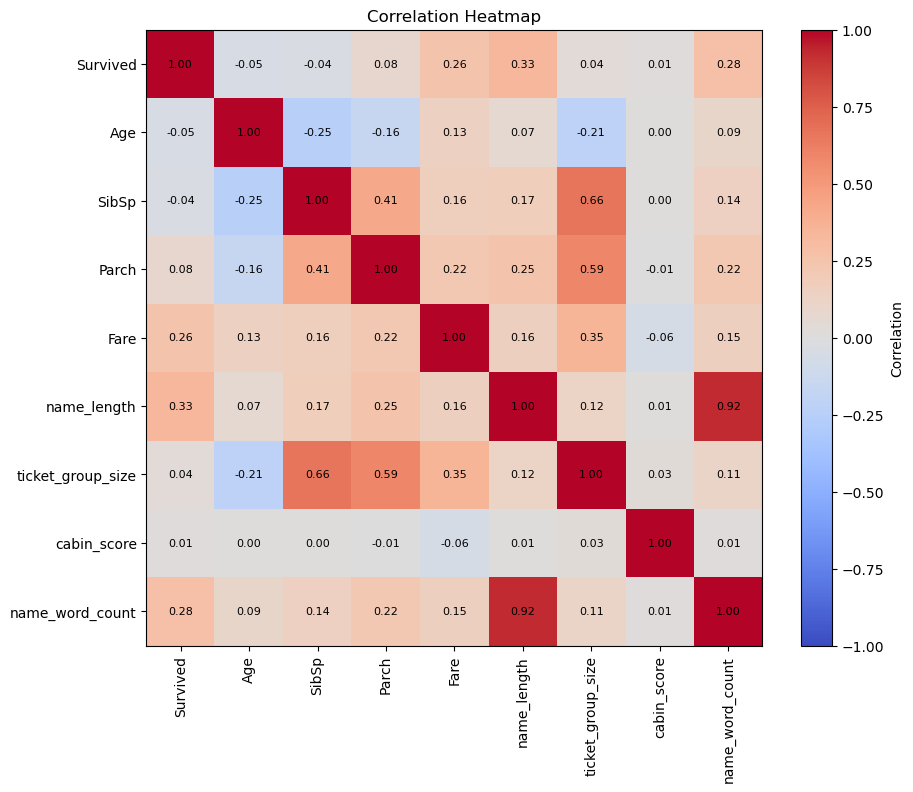

In [38]:
passengers_numeric = passengers.select_dtypes(include="number")

corr = passengers_numeric.corr()

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)

ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Correlation")

for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}", ha="center", va="center", fontsize=8)

plt.title("Correlation Heatmap")
plt.show()

In [39]:
def calculate_vif(data):
    return pd.DataFrame({
        "feature": data.columns,
        "VIF": [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    })

X_numeric = passengers.select_dtypes(include="number").drop(columns=["Survived"], errors="ignore")

max_vif = 999

while True:
    
    vif_data = calculate_vif(X_numeric)
    max_vif = vif_data['VIF'].max()
    
    if max_vif <= 10:
        break

    largest_multicoliearity = vif_data.sort_values("VIF", ascending=False).iloc[0]["feature"]
    X_numeric = X_numeric.drop(columns=[largest_multicoliearity])

    print(f"Feature to Remove: {largest_multicoliearity} with VIF={round(max_vif, 2)}")

print("\nFeatures to Not Removed:")
print(calculate_vif(X_numeric))

Feature to Remove: name_word_count with VIF=75.62

Features to Not Removed:
             feature       VIF
0                Age  4.785696
1              SibSp  2.247423
2              Parch  1.926508
3               Fare  1.713366
4        name_length  6.377345
5  ticket_group_size  5.900629
6        cabin_score  3.424312


In [40]:
passengers = passengers.drop(columns=["name_word_count"])

# Taking a look at the final passengers dataframe

In [41]:
passengers.head(10)

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,name_length,title_group,ticket_group_size,cabin_score
0,0,3,22.0,1,0,7.2500,S,23,Mr,1,6.134152
1,1,1,38.0,1,0,71.2833,C,51,Mrs,1,4.182430
2,1,3,26.0,0,0,7.9250,S,22,Miss,1,9.327285
3,1,1,35.0,1,0,53.1000,S,44,Mrs,2,8.660639
4,0,3,35.0,0,0,8.0500,S,24,Mr,1,0.452187
5,0,3,22.0,0,0,8.4583,Q,16,Mr,1,0.263670
6,0,1,54.0,0,0,51.8625,S,23,Mr,1,3.764634
7,0,3,2.0,3,1,21.0750,S,30,Master,4,8.105533
8,1,3,27.0,0,2,11.1333,S,49,Mrs,3,9.872761
9,1,2,14.0,1,0,30.0708,C,35,Mrs,2,1.504169


In [42]:
passengers.describe()

,Survived,Age,SibSp,Parch,Fare,name_length,ticket_group_size,cabin_score
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,28.456981,0.523008,0.381594,32.204208,26.965208,1.787879,4.956762
std,0.486592,13.489817,1.102743,0.806057,49.693429,9.281607,1.361142,2.915177
min,0.000000,0.420000,0.000000,0.000000,0.000000,12.000000,1.000000,0.046320
25%,0.000000,21.000000,0.000000,0.000000,7.910400,20.000000,1.000000,2.325861
50%,0.000000,25.000000,0.000000,0.000000,14.454200,25.000000,1.000000,4.954913
75%,1.000000,36.000000,1.000000,0.000000,31.000000,30.000000,2.000000,7.479345
max,1.000000,80.000000,8.000000,6.000000,512.329200,82.000000,7.000000,9.997177


# Splitting Data

In [43]:
X_columns = ["Pclass", "Age", "SibSp", "Parch", "Fare", "Embarked", "name_length", "title_group", "ticket_group_size", "cabin_score"]
X = passengers[X_columns]

y = passengers.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=seed) # Stratified

# Dummy Encoding

In [44]:
categorical_columns = ["Pclass", "Embarked", "title_group"]

X_train = pd.get_dummies(X_train, columns=categorical_columns, drop_first=True)

X_test = pd.get_dummies(X_test, columns=categorical_columns, drop_first=True)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Standardizing

In [45]:
numeric_columns = ["Age", "SibSp", "Parch", "Fare", "name_length", "ticket_group_size", "cabin_score"]

scaler = StandardScaler()

X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])

X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

# Taking a look at the final X_train dataframe

In [49]:
X_train.head()

,Age,SibSp,Parch,Fare,name_length,ticket_group_size,cabin_score,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,title_group_Miss,title_group_Mr,title_group_Mrs,title_group_Other
486,0.467281,0.536677,-0.451483,1.240397,2.175192,0.183190,1.441830,False,False,False,True,False,False,True,False
238,-0.723658,-0.464720,-0.451483,-0.436028,0.453849,-0.572186,1.404873,True,False,False,True,False,True,False,False
722,0.392847,-0.464720,-0.451483,-0.383310,0.131098,-0.572186,-0.958719,True,False,False,True,False,True,False,False
184,-1.840163,-0.464720,1.951631,-0.192999,0.884185,-0.572186,-1.293701,False,True,False,True,True,False,False,False
56,-0.574791,-0.464720,-0.451483,-0.436028,-1.052325,-0.572186,-0.348058,True,False,False,True,True,False,False,False


In [50]:
X_train.describe()

,Age,SibSp,Parch,Fare,name_length,ticket_group_size,cabin_score
count,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02
mean,2.260334e-16,6.648042e-17,-4.254747e-17,8.642455e-17,-5.850277e-17,7.445807e-17,-7.977650e-18
std,1.000749e+00,1.000749e+00,1.000749e+00,1.000749e+00,1.000749e+00,1.000749e+00,1.000749e+00
min,-2.106636e+00,-4.647201e-01,-4.514834e-01,-6.574426e-01,-1.590245e+00,-5.721859e-01,-1.669374e+00
25%,-5.747907e-01,-4.647201e-01,-4.514834e-01,-4.909431e-01,-7.295735e-01,-5.721859e-01,-9.328323e-01
50%,-2.026223e-01,-4.647201e-01,-4.514834e-01,-3.651669e-01,-1.916540e-01,-5.721859e-01,1.471626e-02
75%,5.417145e-01,5.366767e-01,-4.514834e-01,-1.428587e-02,3.462656e-01,1.831899e-01,8.667354e-01
max,3.816797e+00,7.546455e+00,6.757861e+00,1.014610e+01,5.940629e+00,3.960069e+00,1.722734e+00
